#Chapter9

##복습 + 나만의 신경망에서 노드수를 지정할 수 있게 만들기

e의 평균: -0.0 e의 분산: 0.51


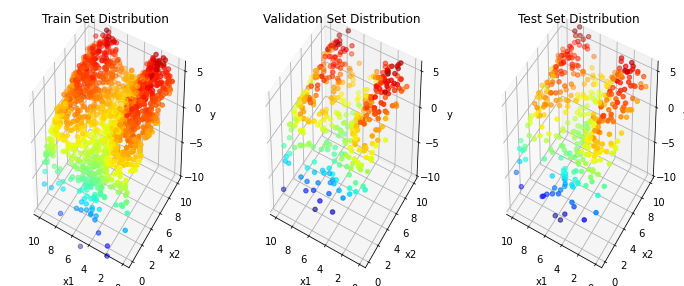

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#============x1, x2, 잡음 생성후 y를 만들기 =========
num_data = 2400 #데이터의 수는 2400개
x1 = np.random.rand(num_data) * 10 #x1은 *10을 함으로써 0부터 10까지의 랜덤 숫자를 총 2400개를 균일하게 생성한다. 

x2 = np.random.rand(num_data) * 10 #np.random.rand(데이터의 갯수) * 크기 (크기 설정 안하면 0부터 1까지 균등한 분포)

e = np.random.normal(0, 0.5, num_data) #잡음은 가우시안 분포(정규분포)를 이용하여 평균은 0, 표준편자는 0.5인 난수 생성
print("e의 평균:",np.round(e.mean()), "e의 분산:", np.round(e.std(), 2))

X = np.array([x1, x2]).T #파이토치는 데이터의 형태중 맨처음에 오는 숫자를 데이터의 개수로 받아야하기 때문에 2400, 2로 X데이터 생성 
y = 2*np.sin(x1) + np.log(0.5 * x2 **2) + e #형태는 2400개의 숫자가 나온다. 



#============훈련, 검증 데이터를 나누기===============
train_X, train_y = X[:1600, :], y[:1600] #2400*2인데 x1과 x2가 쌍으로 1600개까지 train_data
val_X, val_y = X[1600:2000, :], y[1600: 2000] #1600부터2000은 validation
test_X, test_y = X[2000:, :], y[2000:] #나머지 400개는 평가 데이터이다. 

#그래프 시각화
#그래프를 그리는 방법: 1. plt.plot(그래프를 1개 그릴 때)
#2.여러개를 그리고 싶으면 fig를 지정 fig = plt.subplot(figsize = (, ))
#3. subplot은 figure에 들어가는 작은 그림이다. add_subplot(1, 3, 1), add_subplot(1, 3, 2), add_subplot(1, 3, 3)
#subplot을 행은 1개 열은 총 3개 그리기 projection = '3d' 3d를 그리기
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 3, 1, projection = '3d')
ax1.scatter(train_X[:,0], train_X[:,1], train_y, c=train_y, cmap = 'jet')#X[0]은 x1. X[1]은 x2이다.

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')

ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()


In [ ]:
import torch
import torch.nn as nn

class MLPModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(MLPModel, self).__init__()
    
    self.linear1 = nn.Linear(input_dim, hidden_dim, output_dim)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    return x

model = MLPModel(2, 200, 1)

모델이름을 설정한 뒤에    
def __init__()의 괄호 부분에 input_dim, hidden_dim, output_dim을 설정하고   
self.linear1 = nn.Linear(input_dim, hidden_dim)      
self.linear2 = nn.Linear(hidden_dim, output_dim)으로 하면   
input, 중간층, 출력층의 노드개수를 마음대로 설정할 수 있다. (입력은 input_dim에 맞추어야 한다.)     

마지막에 model = 모델이름(input_dim, hidden_dim, output_dim)으로 만들면 된다.    
def__init__(): 
부분은 입력인자를 받는 부분이라고 생각하면 편하다.  

In [ ]:
reg_loss = nn.MSELoss()

predicted = torch.Tensor([0, 0, 0, 0])
labels = torch.Tensor([1, 0, 0, 0])
print(reg_loss(predicted, labels))
#기준 변수를 설정 
#기준(예측값, 정답값)에서 오차가 나온다. 

tensor(0.2500)


In [ ]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

lr = 0.005

optimizer = optim.SGD(model.parameters(), lr = lr) #learning_rate를 설정

#epoch는 주어진 데이터를 몇번 보여줄지 결정
list_epoch = []
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []

epoch = 4000 #iteration과 헷갈릴 수 있음 iteration은 파라미터가 한번 업데이트 되는 횟수.
#iteration은 10만개의 데이터를 한번에 training을 할 수 없어서 100개의 배치로 나눠서 훈련을 시킨다.
#이걸로 gradient구하고 iteration을 한다. 
#ieration은 batch_size마다 발생, epoch는 데이터의 전체를 보고 업데이트한다. 
#배치와 미니배치는 차이가 거의 없다.

#===============학습================
for i in range(epoch):
  model.train() #이걸 해줘야 training을 한다. evaluation일 때는 model.eval()을 사용 모드를 결정
  optimizer.zero_grad() #연산 그래프를 초가화 안그러면 연산이 누적되어서 발산 

  input_x = torch.Tensor(train_X)  #np.array, torch.Tensor()
  true_y = torch.Tensor(train_y)   #파이토치로 연산하려면 무조건 입력데이터 텐서로 바꾸기
  pred_y = model(input_x) #model에 input_x를넣으면 된다. 이때 결과값의 형태가 (1600, 1)이다! 엥 true_y는 (1600,)인데?
  loss = reg_loss(pred_y.squeeze(), true_y) #이래서 예측값에서 pred_y.squeeze()를 통해 불필요한 1인 차원을 없앤다.
  loss.backward()    #.squeeze()안하면 학습이 안될 수 있다!! 그리고 gradient알아서 계산한다. 
  optimizer.step()  
  list_epoch.append(i)
  list_train_loss.append(loss.detach().numpy()) #loss값에서 gradient값을 신경 안쓰고 loss라는 순수한 숫자를 원할때 사용
  #loss.item()사용해도 된다.!!!!!

#===============검증================
  model.eval()
  optimizer.zero_grad()
  input_x = torch.Tensor(val_X)
  true_y = torch.Tensor(val_y)
  pred_y = model(input_x)
  loss = reg_loss(pred_y.squeeze(), true_y)
  list_val_loss.append(loss.item())

#=============시험=============
  if i % 200 == 0: #200회의 학습마다 모델이 예측한 분포 그리기
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(test_X)
    true_y = torch.Tensor(test_y)
    pred_y = model(input_x).detach().numpy()
    mae = mean_absolute_error(true_y, pred_y)
    list_mae.append(mae)
    list_mae_epoch.append(i)

    #그림그리기 
    #test_dataset그리기
    fig = plt.figure(figsize = (15, 5))
    ax1 = fig.add_subplot(1, 3, 1, projection = '3d')
    ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c = test_y, cmap = 'jet')

    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_zlabel('y')
    
    ax1.set_zlim(-10, 6)
    ax1.view_init(40, -40)
    ax1.set_title('True test y')
    ax1.invert_xaxis()

    #예측 그리기

    ax2 = fig.add_subplot(1, 3, 2, projection = '3d')
    ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y,  c=pred_y[:,0], cmap='jet')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_zlabel('y')
    ax2.set_zlim(-10, 6)
    ax2.view_init(40, -40)
    ax2.set_title('Predicted test y')
    ax2.invert_xaxis()

    input_x = torch.Tensor(train_X)
    pred_y = model(input_x).detach().numpy() 
    pred_y = pred_y.squeeze()
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y, cmap='jet')

    ax3.set_xlabel('x1')
    ax3.set_ylabel('x2')
    ax3.set_zlabel('y')
    ax3.set_zlim(-10, 6)
    ax3.view_init(40, -40)
    ax3.set_title('Predicted train y')
    ax3.invert_xaxis()
        
    plt.show()
    print(i, loss)



Output hidden; open in https://colab.research.google.com to view.

#9+10 MNIST

데이터 준비하기

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

batch_size = 128

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3801,))])

train_dataset = datasets.MNIST('./data', train = True, download = True,
                               transform = transform)

test_dataset = datasets.MNIST('./data', train = False, download = True, transform = transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000]) #6만개 데이터를 5만, 1만으로 나눔
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 128, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = False)







50000 10000 10000


from torchvision import datasets, trasnforms   

from torchvision에서 2가지 가져와야한다.   
datasets: 기본 데이터셋들을 가리킨다.(cifar10, MNIST등등)   
필요한 인자:   
1. 경로 './data'
2. 훈련여부: 학습데이터만 True로 설정   
3. 다운로드여부(Colab은 True로 하는 것이 좋다.)     
4. 어떤식으로 변환할건지 transforms = ~~   
transforms: transforms.Compose([])를 한다음 사진파일을 변환한다.   
1. transforms.ToTensor()  텐서형태로 변환   
2. transforms.Normalize((평균), (표준편차))   
그외 RandomHorizontalFlip(), ColorJitter()등으로 Data augmentation을 할 수 있다.(학습데이터에만 사용할 것)

torch.utils.data    
1. DataLoader(훈련데이터, batch_size = 배치사이즈, shuffle = boolean)   
배치사이즈별로 데이터를 로딩하게 만든다. 셔플 여부를 묻는다.   
데이터가 ([배치사이즈, 색깔, 행, 열])로 나오게 된다.   

2. random_split(나누고 싶은 데이터, [훈련데이터의 개수, 검증데이터의 개수])    
데이터의 개수를 랜덤으로 나눈다. 

<정리>   
1. 데이터 불러오기
2. 데이터 transform   
3. 훈련데이터만 검증과 따로 나누기   
4. DataLoader활용    




데이터를 시각화

torch.Size([128, 1, 28, 28])


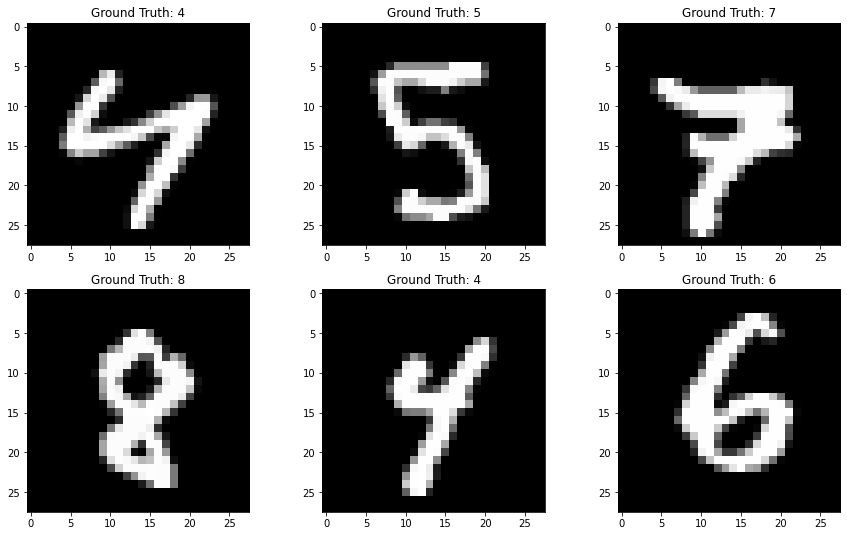

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

example_data, example_label = next(iter(train_loader)) #next(iter로 데이터 불러오기)
print(example_data.size())

fig = plt.figure(figsize = (15, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(np.squeeze(example_data[i]), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_label[i]))
plt.show()




- example_data, example_label = next(iter(train_loader))     
next(iter)로 데이터와 정답을 가져올 수 있다.


- 보통 pytorch로 사진을 그리고 싶으면
example_data = example_data[i]    
  plt.imshow(np.transpose(example_data, (2, 1, 0)))     

<br>- example_image = example_data[i]로 배치에서 이미지를 가져와서   
np.transpose(1, 2, 0)으로 바꿔서 (height, width,  channel)로 바꿔야 그림이 나온다.  
plt.imshow(tensor_image.permute(1, 2, 0))을 사용하기도 한다.

plt.imshow(np.squeeze(example_data[i]), cmap='gray', interpolation='none')   
흑백사진이라서 색깔차원을 없애도 그릴 수 있다.

In [ ]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

과제파트) 층수를 직접 정의할 수 있는 MLP를 만들기 

In [ ]:
hidden_list = [256, 128, 64]

class MLPModel2(nn.Module):
  def __init__(self, in_features, out_features, hidden_param_list):
    super(MLPModel2, self).__init__()
    self.linear1 = nn.Linear(in_features, hidden_param_list[0], bias = True)
    self.hidden = nn.ModuleList()
    self.relu = nn.ReLU()
    for i in range(len(hidden_param_list)-1):
      self.hidden.append(nn.Linear(hidden_param_list[i], hidden_param_list[i+1], bias = True ))
    self.linear2 = nn.Linear(hidden_param_list[-1], out_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    for layer in self.hidden:
      x = self.relu(layer(x))
    x = self.linear2(x)
    return x 


model2 = MLPModel2(784, 10, hidden_list )
criterion = nn.CrossEntropyLoss()

nn.Modulist를 만들고 은닉층 파라미터 리스트를 만든다.  
리스트 안에 있는 파라미터만큼 선형 연산을 하며, 층이 쌓이는 것을 볼 수 있다.

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model2.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model2.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        #torch.Size([128, 1, 28, 28])라서 색깔의 차원을 제거
        input_X = input_X.view(-1, 784) 
        #배치사이즈는 살리고 (128, 28, 28)을 (128, 784)로 변환하는 경우 torch.flatten(input_dim =1)이 있다. 
        pred_y = model2(input_X)

        loss = criterion(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.detach().numpy()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = torch.flatten(input_X, start_dim = 1)
            pred_y = model2(input_X)

            loss = criterion(pred_y.squeeze(), true_y)
            val_loss += loss.detach().numpy()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model2(input_X).max(1, keepdim=True)[1].squeeze()
            #_, pred_y = torch.max(model(input_X), dim = 1)
            correct += pred_y.eq(true_y).sum().item()
            #correct += (pred_y == true_y).sum().item()

        acc = correct / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Number of 101770 parameters
Epoch: 0, Train Loss: 2.2626706547749316, Val Loss: 2.198013679890693, Test Acc: 40.38%
Epoch: 1, Train Loss: 1.9812739111883255, Val Loss: 1.6223927766461916, Test Acc: 67.86999999999999%
Epoch: 2, Train Loss: 1.1799008794452832, Val Loss: 0.8100030218498616, Test Acc: 78.62%
Epoch: 3, Train Loss: 0.6930489042378447, Val Loss: 0.5725893853585932, Test Acc: 83.45%
Epoch: 4, Train Loss: 0.5401154128486848, Val Loss: 0.4710653665699536, Test Acc: 86.36%
Epoch: 5, Train Loss: 0.4602438214489871, Val Loss: 0.41113406853585305, Test Acc: 87.92999999999999%
Epoch: 6, Train Loss: 0.4098853785973376, Val Loss: 0.37267977659460866, Test Acc: 88.77000000000001%
Epoch: 7, Train Loss: 0.37591253095270727, Val Loss: 0.3442179238117194, Test Acc: 89.7%
Epoch: 8, Train Loss: 0.34905914623109274, Val Loss: 0.32219618558883667, Test Acc: 90.45%
Epoch: 9, Train Loss: 0.32742668737840774, Val Loss: 0.3056587812644017, Test Acc: 90.94%
Epoch: 10, Train Loss: 0.3094030242136982,

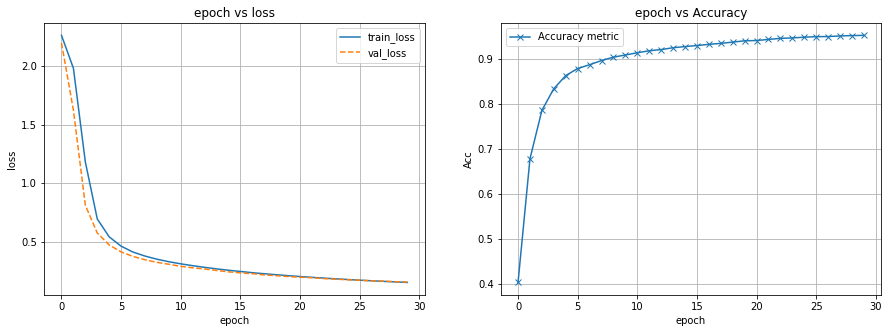

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()

nn.Modulist를 해야하는 이유: 그냥 단순히 리스트를 만들어  
층을 추가한다면, optimizer에 등록이 안되서  
리스트안의 파라미터들을 학습을 할 수가 없다.    
라스트에 단순히 추가를 하면,   
hiddenlayer의 층을 바꿔도 파라미터수가 바뀌지 않는다. 

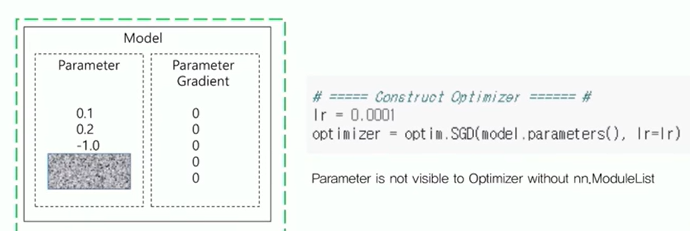

In [ ]:
class Mymodel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Mymodel, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.linear1(x)
    x = self.linear2(x)
    return x

model = Mymodel(784, 128, 10)

criterion = nn.CrossEntropyLoss()


    

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        #torch.Size([128, 1, 28, 28])라서 색깔의 차원을 제거
        input_X = input_X.view(-1, 784) 
        #배치사이즈는 살리고 (128, 28, 28)을 (128, 784)로 변환하는 경우 torch.flatten(input_dim =1)이 있다. 
        pred_y = model(input_X)

        loss = criterion(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.detach().numpy()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = torch.flatten(input_X, start_dim = 1)
            pred_y = model(input_X)

            loss = criterion(pred_y.squeeze(), true_y)
            val_loss += loss.detach().numpy()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            #_, pred_y = torch.max(model(input_X), dim = 1)
            correct += pred_y.eq(true_y).sum().item()
            #correct += (pred_y == true_y).sum().item()

        acc = correct / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))


Number of 101770 parameters
Epoch: 0, Train Loss: 1.1197557911238707, Val Loss: 0.629756108114991, Test Acc: 85.47%
Epoch: 1, Train Loss: 0.5459305084574863, Val Loss: 0.4558529152145869, Test Acc: 88.19%
Epoch: 2, Train Loss: 0.4430036406459101, Val Loss: 0.3959114894836764, Test Acc: 89.24%
Epoch: 3, Train Loss: 0.39907975571082377, Val Loss: 0.36537525925455216, Test Acc: 89.89%
Epoch: 4, Train Loss: 0.3743366214930249, Val Loss: 0.34691362969483003, Test Acc: 90.31%
Epoch: 5, Train Loss: 0.3578827118934573, Val Loss: 0.3344762862860402, Test Acc: 90.48%
Epoch: 6, Train Loss: 0.34599917665924257, Val Loss: 0.32574134084242806, Test Acc: 90.75999999999999%
Epoch: 7, Train Loss: 0.33717472432062146, Val Loss: 0.31820118389552154, Test Acc: 90.9%
Epoch: 8, Train Loss: 0.329874711535166, Val Loss: 0.3129531907129891, Test Acc: 91.03%
Epoch: 9, Train Loss: 0.32408010384158403, Val Loss: 0.30830506207067754, Test Acc: 91.25%
Epoch: 10, Train Loss: 0.3191163121434429, Val Loss: 0.304734513

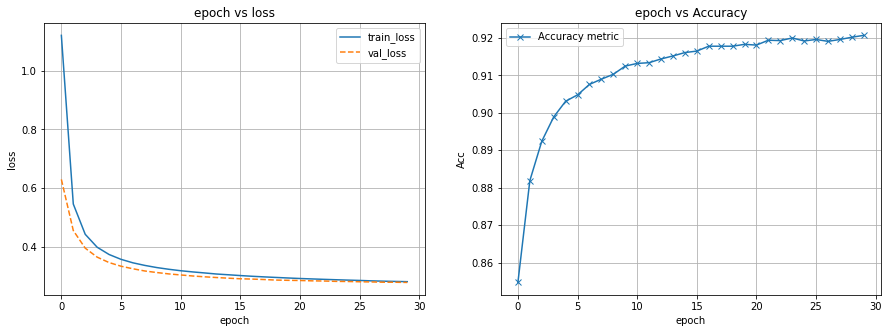

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()

- MLP는 이미지파일을 꼭! flatten()해야한다. (한줄로 늘이기)

1. input_X = input_X.squeeze() 
색깔의 차원을 제거한다. 흑백이라 색깔이 1이다. 

2.  input_X = input_X.view(-1, 784)   
배치사이즈는 살리고 (128, 28, 28)을 (128, 784)로 변환하는 경우 torch.flatten(input_dim =1)이 있다. 

3. 1번과 2번과정을 합친 것:   
input_X = torch.flatten(start_dim = 1, end_dim = 3)     
배치사이즈는 살리고, 색깔인 차원부터 행과 열까지 평탄화 한다는 뜻이다.   
start_dim을 꼭 설정해야 하는 것을 잊지말자.   


4. pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()     
최대 값의 라벨 찾기    
_, pred_y = torch.max(model(input_X), dim = 1)로 표현가능     

5. correct += pred_y.eq(true_y).sum().item() 
pred_y.eq(true_y)로 둘이 같은 지 비교한다음,  
128개의 배치중 라벨이 같은 경우의 수를 sum()을 하고 .item()으로 정수로 취한다.   

correct += (pred_y == true_y).sum().item()으로 사용 가능   
acc = correct / len(test_loader.dataset)
반복문이 끝나고!! 정확도를 구한다. (print할 때는 100을 곱한다.)

+model.eval()을 하고 with torch.no_grad():를 하여 오류역전파가 전달 안되게 만들어야한다음,   
 for input_X, true_y in test_loader:로 반복문을 설정한다.

loss.backward()와 optimizer.step의 관계:   
optimizer = optim.SGD(model.parameters(), )

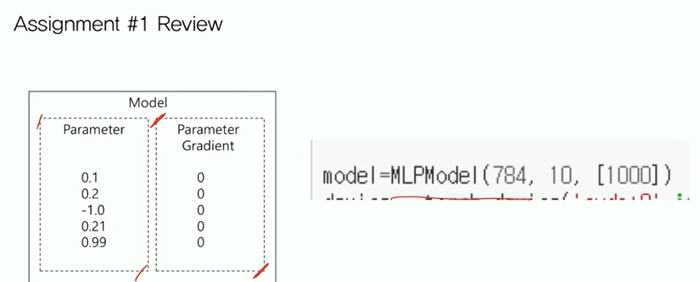

MLP모델을 생성하면 파라미터가 랜덤으로 생성. 파라미터의 gradient가 생성
torch.Tensor()은 gradient도 tensor로 저장한다.   


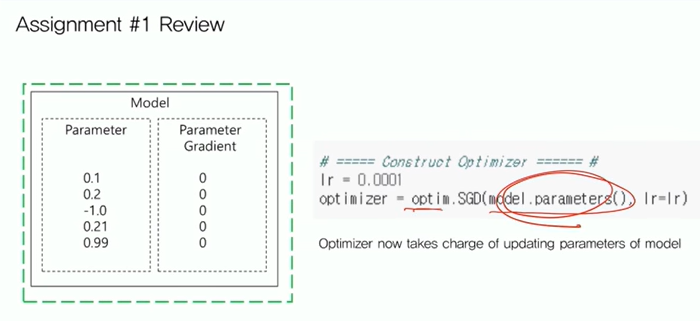

optimizer이 모델의 파라미터를 최적화하기로 지정.

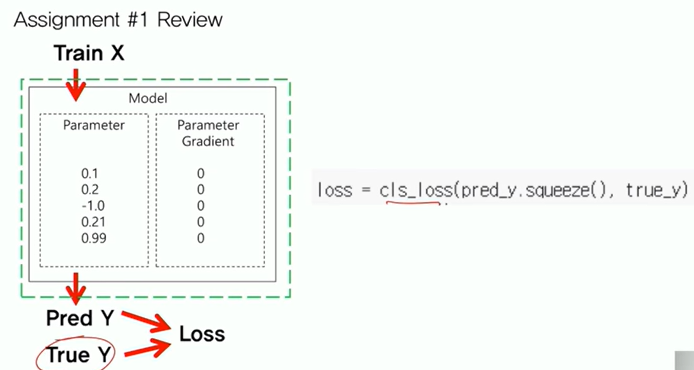

모델이 입력을 받고 예측을 한다음, 정답과 비교하여 손실값을 생성

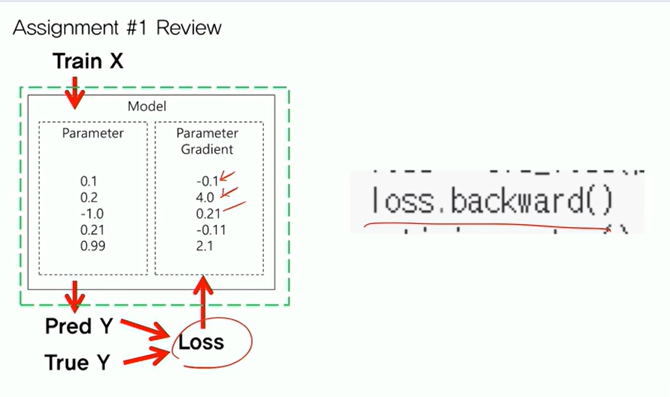

오차함수를 편미분한 오류역전파가 앞으로 전달된다.

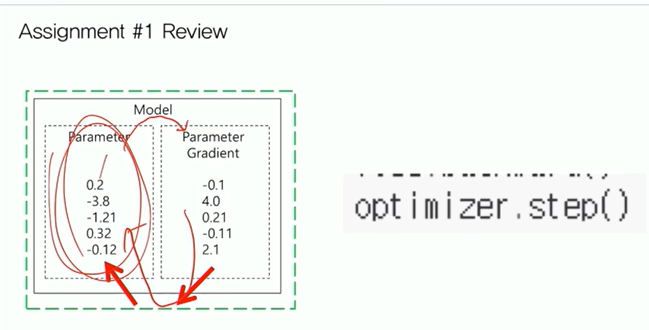

편미분한 오류역전파를 보고 최적화를 수행

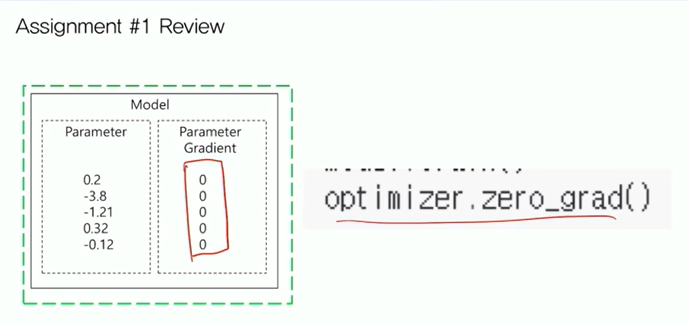